In [25]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import data.utils_dataloader as utils_met
import cucim.skimage.metrics as met

import utils
import data.HCP_dataset_h5_arb as HCP_dataset

In [26]:
shape_3t = [145,174,174]
shape_7t = [173,207,173]

In [27]:
[round(shape_7t[i]/shape_3t[i],1) for i in range(3)]

[1.2, 1.2, 1.0]

7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 174

In [28]:
import h5py

loaded = {}
loaded_gt ={}

def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    for i in ids:
        name = path['3T'][i]['h5']
        res_vol = h5py.File(name, 'r')
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:]}
        
        name = path['7T'][i]['GT']
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:]}
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()


In [29]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]

In [30]:
load_data('/storage',ids)

In [31]:
ids

['100610', '102311', '102816', '104416', '105923']

In [32]:
data_7t= loaded_gt[ids[3]]['vol0']
data_3t= loaded[ids[3]]['vol0']

In [33]:
data_3t.shape

(145, 174, 143, 7)

In [34]:
def blk_points_pair(datalr,datahr,blk_size = [16,16,4],sca = [1,1,1]):
    
    x,y,z,c = [np.arange(datalr.shape[i]) for i in range(len(datalr.shape))]
    
    shpind = np.nonzero(datalr)
    xmin,xmax = np.min(shpind[0]),np.max(shpind[0])
    ymin,ymax = np.min(shpind[1]),np.max(shpind[1])
    zmin,zmax = np.min(shpind[2]),np.max(shpind[2])
    
    len_lr = [xmax - xmin + 1,ymax - ymin + 1,zmax - zmin + 1]
    n = [int(round(len_lr[i] / blk_size[i])) for i in range(3)]
    
    # determine starting and ending indices of each block
    
    lr_start = [xmin,ymin,zmin]
    lr_end = [xmax - blk_size[0] + 1,ymax - blk_size[1] + 1,zmax - blk_size[2] + 1]
    
    shpind = np.nonzero(datahr)
    xmin,xmax = np.min(shpind[0]),np.max(shpind[0])
    ymin,ymax = np.min(shpind[1]),np.max(shpind[1])
    zmin,zmax = np.min(shpind[2]),np.max(shpind[2])
    
    blk_size_hr = [round(blk_size[i]*sca[i]) for i in range(3)]
    hr_start = [xmin,ymin,zmin]
    hr_end = [xmax - blk_size_hr[0] + 1,ymax - blk_size_hr[1] + 1,zmax - blk_size_hr[2] + 1]
    
    ranges_lr = [np.round(np.linspace(lr_start[i], lr_end[i], n[i])) for i in range(3)]
    ranges_hr = [np.round(np.linspace(hr_start[i], hr_end[i], n[i])) for i in range(3)]
    
    ind_block_lr = []
    ind_block_hr = []
    count = 0
    
    scale_t = [blk_size[i]/blk_size_hr[i] for i in range(0,3)]
#     print(sca,scale_t)
    offset = [(round((sca[i]-1)*blk_size[i])) * scale_t[i] for i in range(3)]
    offset = [[i//2,i//2] if i%2==0 else [i//2,i//2+1] for i in offset]
    print(offset)
#     offset = [[0,0],[0,0],[0,0]]
    for ii in np.arange(0, ranges_lr[0].shape[0]):
        for jj in np.arange(0, ranges_lr[1].shape[0]):
            for kk in np.arange(0, ranges_lr[2].shape[0]):
                
                temp_lr = np.array([ranges_lr[0][ii] - offset[0][0], ranges_lr[0][ii]+blk_size[0]-1 + offset[0][1], 
                                    ranges_lr[1][jj] - offset[1][0], ranges_lr[1][jj]+blk_size[1]-1 + offset[1][1], 
                                    ranges_lr[2][kk] - offset[2][0], ranges_lr[2][kk]+blk_size[2]-1 + offset[2][1]]).astype(int)
                
                temp_hr = np.array([ranges_hr[0][ii], ranges_hr[0][ii]+blk_size_hr[0]-1,
                                    ranges_hr[1][jj], ranges_hr[1][jj]+blk_size_hr[1]-1,
                                    ranges_hr[2][kk], ranges_hr[2][kk]+blk_size_hr[2]-1]).astype(int)
                
                curr_blk = datalr[temp_lr[0]:temp_lr[1]+1, temp_lr[2]:temp_lr[3]+1, temp_lr[4]:temp_lr[5]+1, ...]
                curr_blk_hr = datahr[temp_hr[0]:temp_hr[1]+1, temp_hr[2]:temp_hr[3]+1, temp_hr[4]:temp_hr[5]+1, ...]
                if((np.count_nonzero(curr_blk)/curr_blk.size > 0.65) and (np.count_nonzero(curr_blk_hr)/curr_blk_hr.size > 0.65)):
                    ind_block_lr.append(temp_lr)
                    ind_block_hr.append(temp_hr)
                    count = count + 1

                    
    
    ind_block_lr = np.stack(ind_block_lr)
    ind_block_lr = ind_block_lr.astype(int)
    ind_block_hr = np.stack(ind_block_hr)
    ind_block_hr = ind_block_hr.astype(int)
    # print(ind_block)
    return ind_block_lr,ind_block_hr


def extract_block(data, inds,inp = False , blk_size = [16,16,16]):
        blocks = []
        if(len(data.shape) == 4):
            blk_size.append(data.shape[-1])
        for ii in np.arange(inds.shape[0]):
            inds_this = inds[ii, :]
            if(inp == True):
                curr_blk = data[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1, ...]
                curr_blk = torch.permute(curr_blk, (3,0,1,2))
                curr_blk = torch.unsqueeze(curr_blk, 0)
#                 print(curr_blk.shape,torch.Size(blk_size))
                curr_blk = torch.nn.functional.interpolate(curr_blk,size = torch.Size(blk_size[:3]))
                curr_blk = torch.permute(curr_blk, (2,3,4,1,0))
            else:
                curr_blk = data[inds_this[0]:inds_this[1]+1, inds_this[2]:inds_this[3]+1, inds_this[4]:inds_this[5]+1, ...]
            # if(np.count_nonzero(curr_blk)/curr_blk.size > 0.6):
            # print(curr_blk.shape)
            blocks.append(curr_blk)
        return np.stack(blocks, axis=0)

In [35]:
t3_vol = loaded[ids[0]]['vol0'].shape
t7_vol = loaded_gt[ids[0]]['vol0'].shape
sca = [t7_vol[i]/t3_vol[i] for i in range(3)]
print(sca,t3_vol,t7_vol)

[1.193103448275862, 1.1896551724137931, 1.1793103448275861] (145, 174, 145, 7) (173, 207, 171, 7)


In [36]:
# sca = [2,2,2]

In [37]:
data_7t_mask= loaded_gt[ids[0]]['mask'][...,np.newaxis]
data_3t_mask= loaded[ids[0]]['mask'][...,np.newaxis]


In [38]:
print(data_3t_mask.shape,data_7t_mask.shape)

(145, 174, 145, 1) (173, 207, 171, 1)


In [39]:
data_7t= loaded_gt[ids[3]]['vol0']
data_3t= loaded[ids[3]]['vol0']

In [40]:
# data_7t= data_7t* data_7t_mask
# data_3t= data_3t* data_3t_mask

In [49]:
sca = [1.2,1.42,1]

In [50]:
temp = blk_points_pair(data_3t_mask,data_7t_mask,blk_size = [16, 16, 16],sca=sca)
extracted_3t = extract_block(torch.from_numpy(data_3t),temp[0],inp=True,blk_size = [16,16,16])
extracted_7t = extract_block(torch.from_numpy(data_7t),temp[1])

[[1.0, 2.0], [2.0, 3.0], [0.0, 0.0]]


In [51]:
extracted_3t.shape,extracted_7t.shape

((170, 16, 16, 16, 7, 1), (170, 19, 23, 16, 7))

In [52]:
temp[0].shape,temp[1].shape

((170, 6), (170, 6))

In [53]:
temp[0][20]

array([30, 48, 79, 99, 40, 55])

In [54]:
(temp[0][20][5]-temp[0][20][4])//2

7

In [55]:
l=10
import random
samples = [random.randint(0,len(temp[0])-1) for i in range(l)]

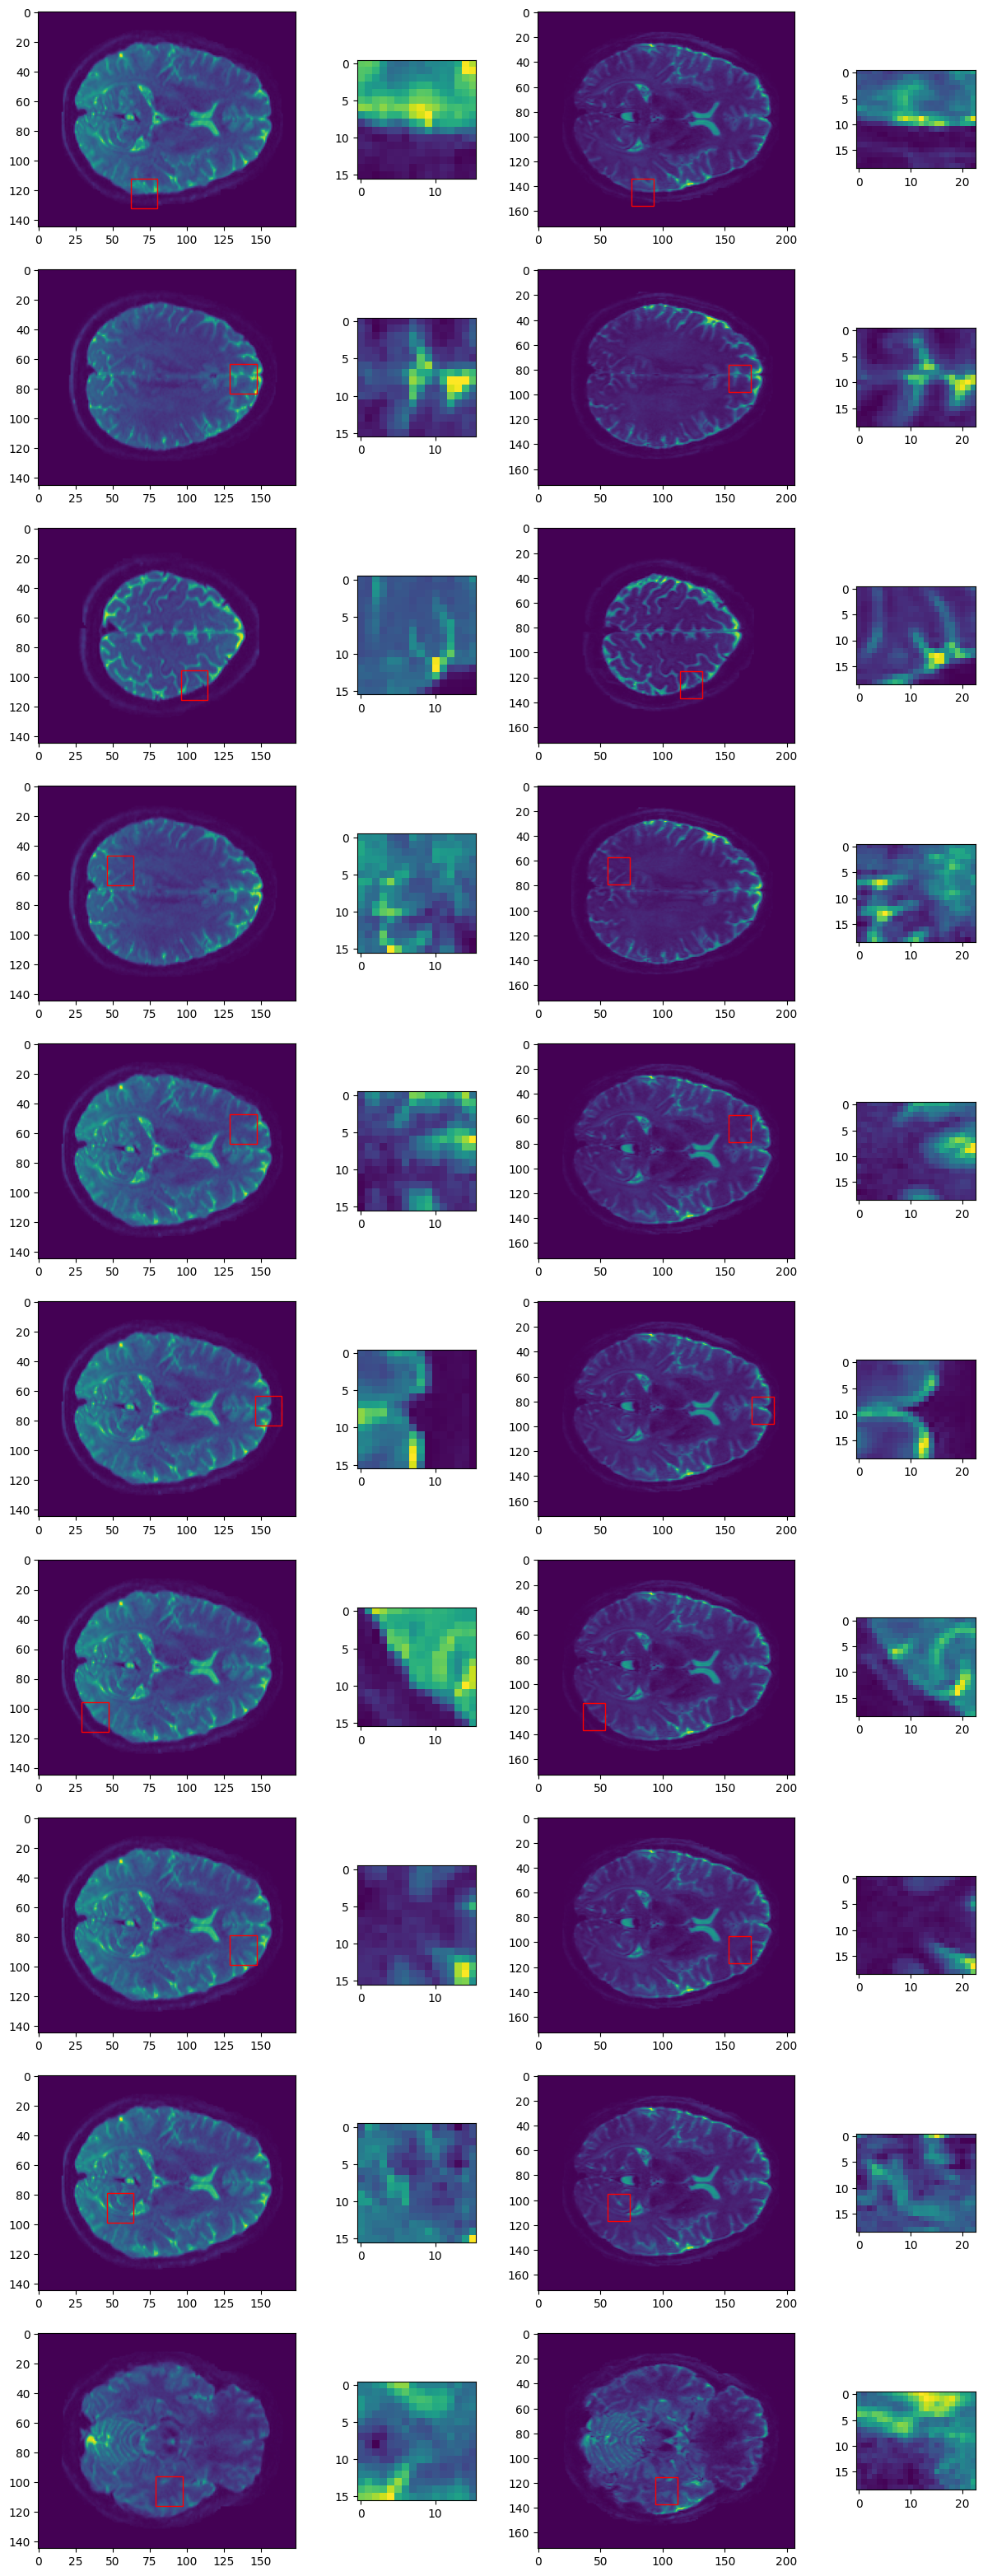

In [56]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
# print(z,temp[1][z])
# Create a figure and axis
l=10
fig, ax = plt.subplots(l,4,gridspec_kw={'width_ratios': [2.5, 1,2.5,1]})

# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)
for i in range(l):
    z = samples[i]
    img = temp[0][z]
    sliceee = (img[5]-img[4])//2
    y,x,w,d = img[0],img[2],int(img[1]-img[0]),int(img[3]-img[2])
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,img[4] + sliceee,0])
    ax[i][1].imshow(extracted_3t[z][:,:,0,0])
    
    img = temp[1][z]
    sliceee = (img[5]-img[4])//2
    y,x,w,d = img[0],img[2],int(img[1]-img[0]),int(img[3]-img[2])
    ax[i][2].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][2].imshow(data_7t[:,:,img[4] + sliceee,0])
    ax[i][3].imshow(extracted_7t[z][:,:,0,0])
plt.show()

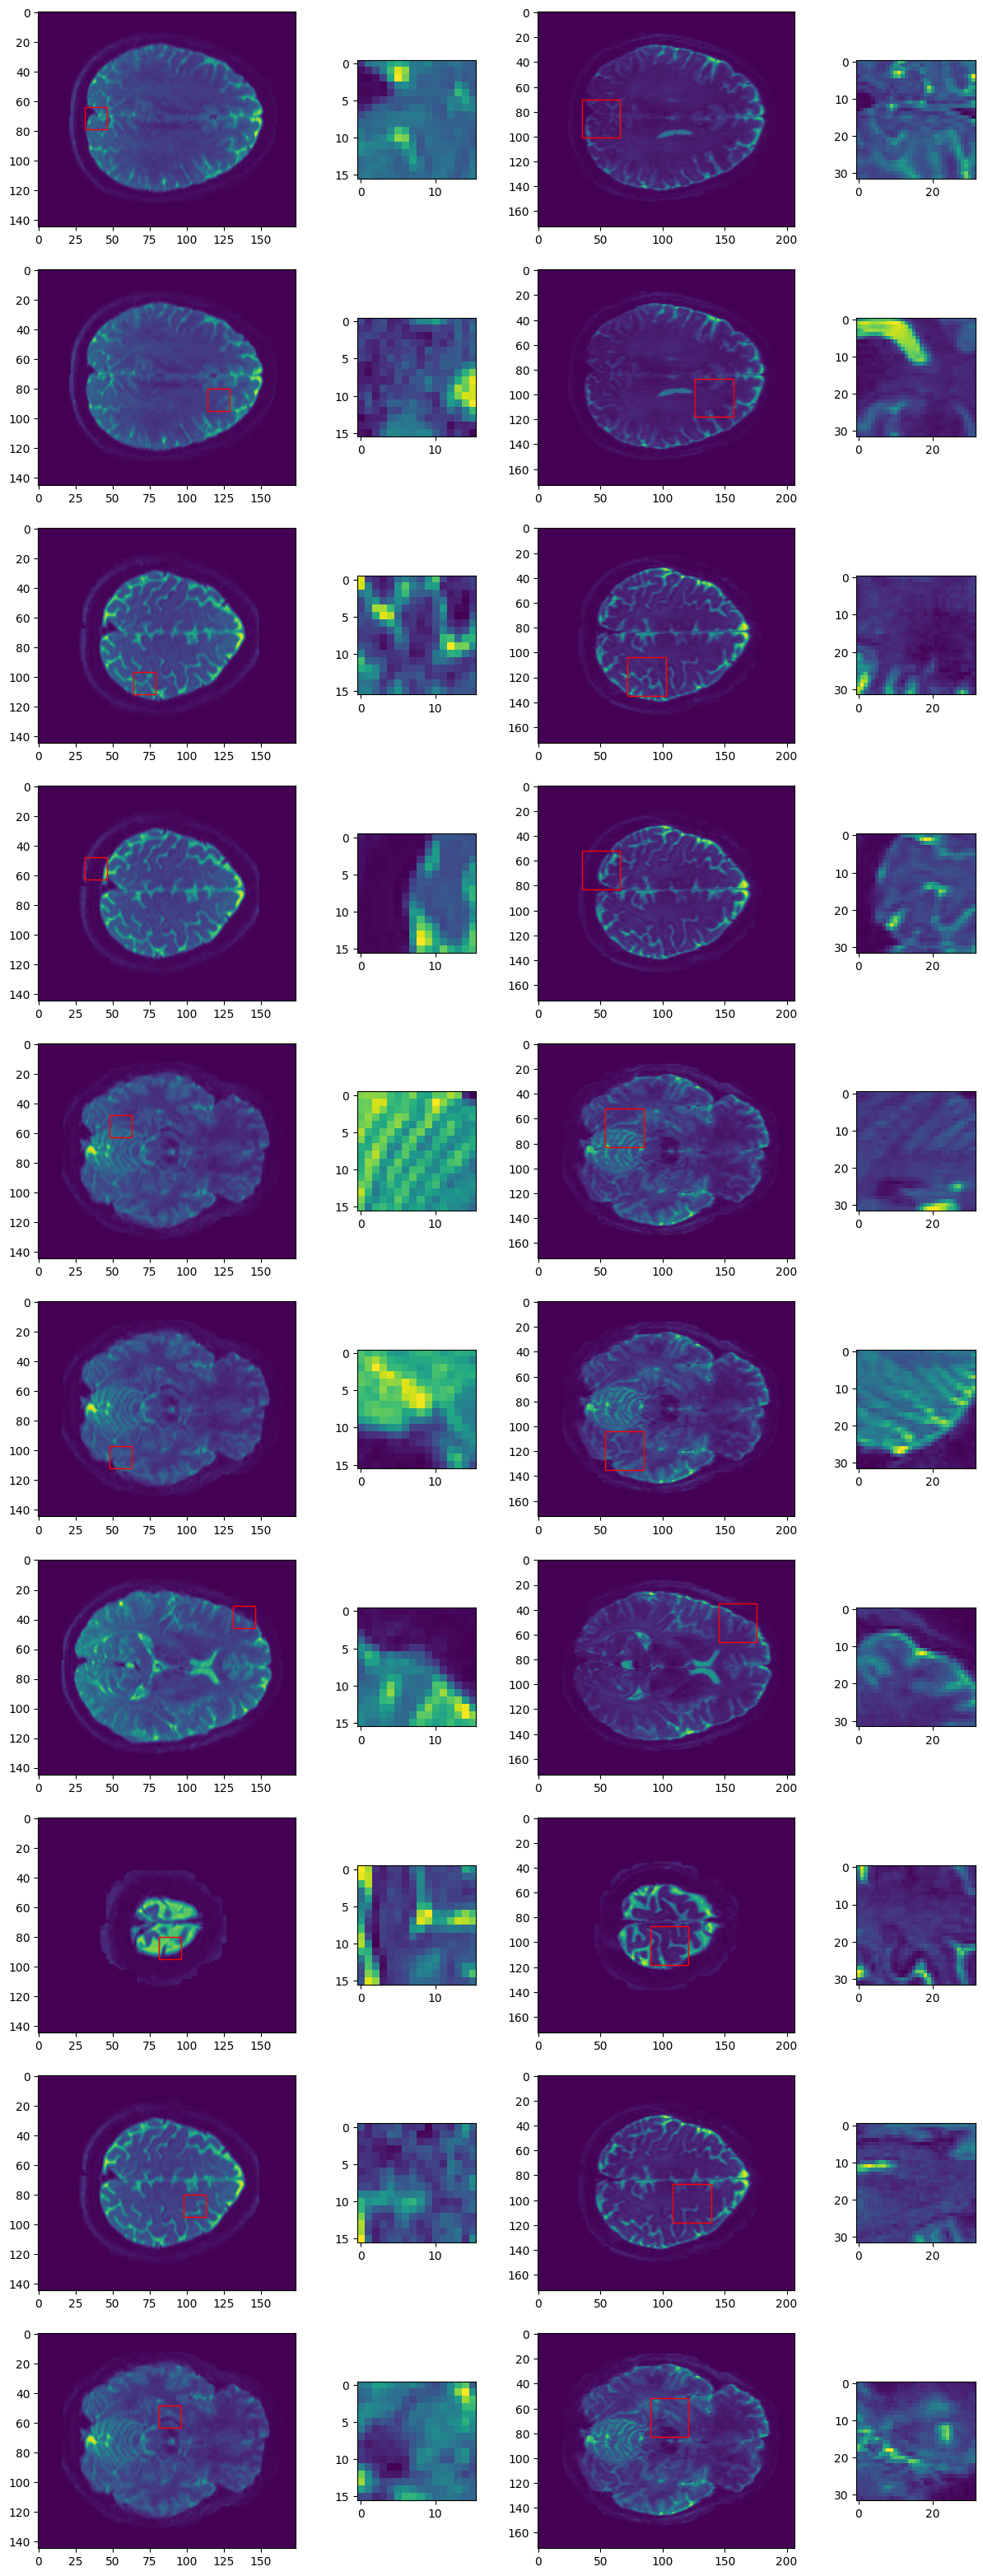

In [86]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
# print(z,temp[1][z])
# Create a figure and axis
l=10
fig, ax = plt.subplots(l,4,gridspec_kw={'width_ratios': [2.5, 1,2.5,1]})

# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)
for i in range(l):
    z = samples[i]
    img = temp[0][z]
    sliceee = (img[5]-img[4])//2
    y,x,w,d = img[0],img[2],int(img[1]-img[0]),int(img[3]-img[2])
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,img[4] + sliceee,0])
    ax[i][1].imshow(extracted_3t[z][:,:,0,0])
    
    img = temp[1][z]
    sliceee = (img[5]-img[4])//2
    y,x,w,d = img[0],img[2],int(img[1]-img[0]),int(img[3]-img[2])
    ax[i][2].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][2].imshow(data_7t[:,:,img[4] + sliceee,0])
    ax[i][3].imshow(extracted_7t[z][:,:,0,0])
plt.show()

In [33]:
import cupy as cp
import cucim.skimage.metrics as metrics
import torch
import torch.nn as nn

def compute_ssim(hr,pred):
    hr = cp.array(hr.squeeze())
    pred = cp.array(pred.squeeze())
    return abs(float(metrics.structural_similarity(hr,pred,channel_axis =3,data_range=1,win_size=3)))

def compute_psnr(hr,pred):
    hr = cp.array(hr.squeeze())
    pred = cp.array(pred.squeeze())
    return float(metrics.peak_signal_noise_ratio(hr,pred,data_range=1))



In [247]:
temp = torch.randn(16, 16, 5, 5)

In [248]:
compute_ssim(temp,temp)

1.0